# Classification system

This exercise uses MNIST dataset and several ML algorithms to correctly analyze and classify some images (numbers).

## Fecthing data

In [1]:
# libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

In [2]:
# dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(f'X shape: {X.shape}\nY shape: {y.shape}')

X shape: (70000, 784)
Y shape: (70000,)


With this, we see there are 70,000 images, with each image having 784 features (28 x 28 pixels)

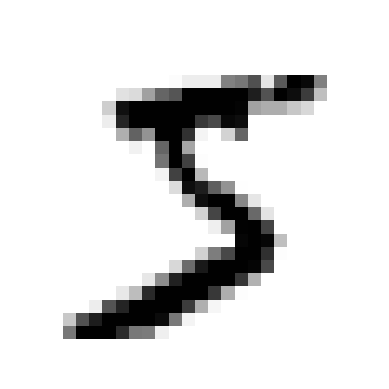

In [4]:
# first look into a pixel
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
# it looks like a 5, but we can confirm it
y[0]

'5'

In [6]:
# we will cast the string to a number
y = y.astype(np.uint8)
y[0]

5

In [7]:
# let's subset out set into train/test sets
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

# we don't need to shuffle the dataset because it's already shuffled

## Binary Classifier

For now, we will only try to classify one number (5), and then generalize to the full training set. We'll start with *Stochastic Gradient Descent* classifier.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

# it correctly predicts that "some_digit" is in fact a number 5!!!

array([ True])

## Performance Measure

### First approach

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
i = 1

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(f'Split {i}: {n_correct/len(y_pred)}\n')
    i+=1

Split 1: 0.9669

Split 2: 0.91625

Split 3: 0.96785



### Second approach

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Around 96% accuracy looks very promising, but we have to consider that this number is only about the 5's class. What about non-5's classes? A classifier would have the same accuracy values? Let's test it!

In [12]:
from sklearn.base import BaseEstimator

class Never5Class(BaseEstimator):

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


never_5_clf = Never5Class()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict

# getting predictions to build the matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

# takes the real values and the predicted ones
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Understanding this matrix can be a bit tricky, so let's interpret by parts:

1. The first column is the class of non-5 images predictions
2. The second column is the class of 5 images predictions
3. The first row is the negative class (real non-5's)
4. The second row is the positive class (real 5's)

Therefore, the cells tell us:

- A1: TRUE NEGATIVE number (non-5's correctly classified)
- B1: FALSE POSITIVE number (5's incorrectly classified)
- A2: FALSE NEGATIVE number (non-5's incorrectly classified)
- B2: TRUE POSITIVE number (5's correctly classified)

A perfect classifier would have only true positives and true negatives, i.e, the secondary diagonal would be 0's.


There are also some important metrics that we can get from this matrix:

1. *Precision*/*Positive Predictive Value* $ = \dfrac{TP}{TP+FP}:\;$ calculates the number of right predictions given the total of 5's predictions <br><b><br>
2. *Recall*/*Sensitivity* $ = \dfrac{TP}{TP+FN}:\;$ calculates the number of right predictions given the total of real 5's <br><br>
3. *F1 Score* $ = 2 \times \dfrac{precision \times recall}{precision + recall}:\;$ calculates the harmonic mean between precision and recall <br><br>
4. *Specificity* $ = \dfrac{TN}{TN+FP}:\;$ calculates the number of right predictions given the total of real non-5's; 1 - *Specificity* gives FP ratio

In [15]:
# getting precision and recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred) # 3530/(3530+687)
recall = recall_score(y_train_5, y_train_pred) # 3530/(3530+1891)
precision, recall

(0.8370879772350012, 0.6511713705958311)

Woww! We have a good precision, but our estimator fails sometimes to detect the number of 5's. We may confirm it with the F1 Score:

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In some contexts, we don't care much about balancing the precision/recall trade-off, because we want to have a specific higher measure. 

For example, if we want to train a classifier that detects safe videos for kids, it's **more critical** to have lower FP numbers (to say a video is safe, when in fact, it isn't) than low FN numbers (to say a video isn't safe, when in fact it is). Therefore, we want a bigger PRECISION instead of a bigger RECALL.

### Precision/Recall Trade-off

Due to the way SGD algorithm works, we can manipulate a threshold to get different precision/recall values, based on our need.

With this, we can also see how raising/decreasing the determined threshold can increase/decrease the recall.

For this, we may use the decision_function() method, that returns a score for each instance, and then compares it to a determined threshold.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores # array([2164.22030239])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # as the threshold is lower than the score, the classifier is right about it's prediction

array([ True])

In [18]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # now, as the threshold increases, the classifier's error is bigger, decreasing the recall

array([False])

So how to decide what's the best threshold?

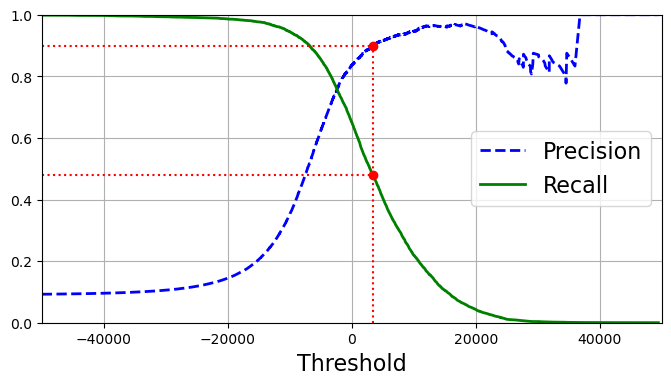

In [19]:
# get the scores for all the predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

# compute the precision/score function
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


# function to plot a trade-off chart
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)
    plt.axis([-50_000, 50_000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]


plt.figure(figsize=(8,4))
plot_precision_recall_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")                 
plt.plot([-50_000, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-50_000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

Another way to clearer way to choose the right trade-off is to look directly into the precision vs recall chart

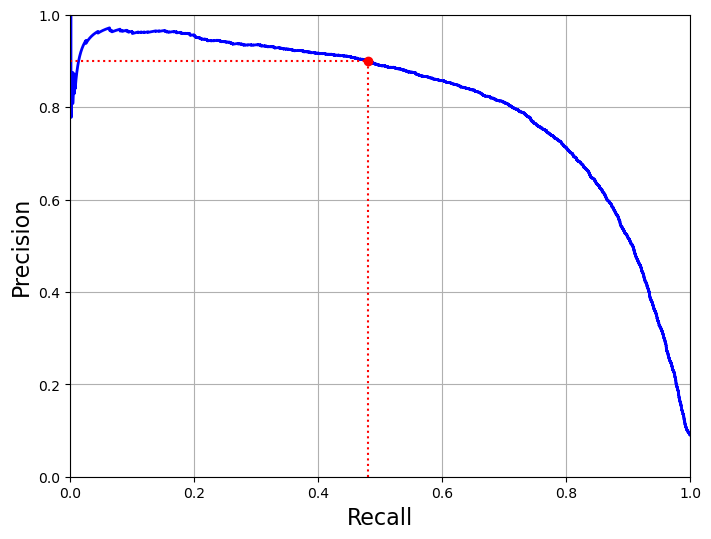

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0,1,0,1])
    plt.grid(True)


plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], 'r:')
plt.plot([0, recall_90_precision], [0.9, 0.9], 'r:')
plt.plot([recall_90_precision], [0.9], 'ro')
plt.show()

With that, we see that precision starts to fall sharply around 80% recall, and that we have a low recall, around 0.48 or 48%.

### ROC Curve

The *Receiver Operating Characteristic Curve* is another useful tool in this context. Through it, we're able to see the *sensitivity/recall* (true positive ratio) by 1 - *specificity* (false positive ratio).

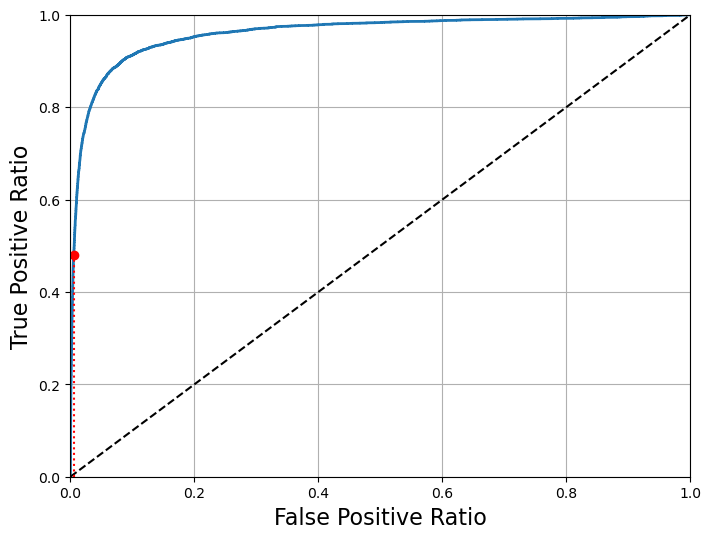

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# plot roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Ratio', fontsize=16)
    plt.ylabel('True Positive Ratio', fontsize=16)
    plt.grid(True)


plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plt.show()

We can also get the area under the curve to compare classifiers. The closer to 1, the better the classifier is.

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores) # we have a good classifier here!!!

0.9604938554008616

In [23]:
# Let's now train a random forest and see how it compares to the previous classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba') # gives probabilities of subjects belonging to a given class

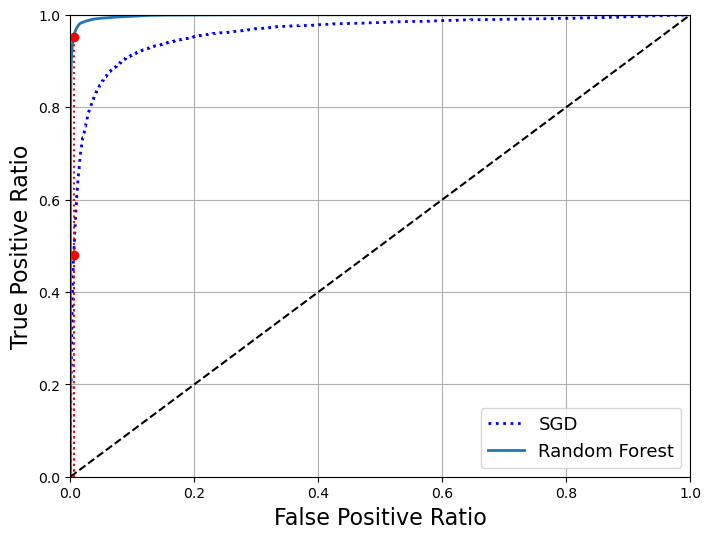

In [24]:
y_scores_forest = y_prob_forest[:,1] # prob. of the positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
recall_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

# plot roc curve comparison
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0, recall_forest], "r:")
plt.plot([fpr_90], [recall_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=13)
plt.show()

Woww, we got a way better classifier, of almost 100% recall and 0 FPR!!! Let's attest it using area under the curve value!!!

In [25]:
roc_auc_score(y_train_5, y_scores_forest) # pretty impressive

0.9983436731328145

In [26]:
# precision and recall score
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [27]:
(precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest))

(0.9905083315756169, 0.8662608374838591)

### Multiclass Classification

When we want an algorithm to classify a certain thing between two or more classes, we are making multiclass classification. This technique can be used with two approaches:

1. *One-vs-the-rest* or *One-versus-all*: a binary classifier is trained on all the classes, e.g. if you have 10 images, you train 10 binary classifiers

2. *One-versus-one*: train a binary classifier for every pair of classes available, resulting in $N \times \dfrac{N-1}{2}$ classifiers. This approach can be time-consuming the more classes you have. 

In [28]:
# using SVM to all the training set (multiclass task)
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hoods, Scikit-learn used the OvO approach, i.e. trained 45 classifiers (which explains the time taken to perform this task)!!!

We can get the scores the prediction gave to each class by calling the `decision_function()` function.

In [29]:
svm_clf.decision_function([some_digit])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

Notice that the highest one was of the class 5!

In [30]:
np.argmax(svm_clf.decision_function([some_digit]))

5

In [31]:
svm_clf.classes_[5]

5

If we want to force the algorithm to use the OvR approach, or OvO in the case it uses the former, we can make it this way:

In [32]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:1000], y_train[:1000]) # it is time-consuming, so I just use a slice of the dataset
ovr_clf.predict([some_digit]) # yeahh, it worked!!!

array([5], dtype=uint8)

In [33]:
# training a SGDClassifier is just as easy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # wow, it's mistaken!

array([3], dtype=uint8)

In [34]:
# let's check the decision scores
sgd_clf.decision_function([some_digit])

# notice that it gets a positive value for 3, and a negative value for 5

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

This time, we didn't need to use OvO or OvR, because `SGDClassifier` is able to classify to several classes.

In [35]:
# cross-validation
cross_val_score(sgd_clf, X_train, y_train, scoring='accuracy', cv=3)

array([0.87365, 0.85835, 0.8689 ])

Not a bad score, but we could improve it by making a standardization to the data

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [38]:
cross_val_score(sgd_clf, X_train_scaled, y_train, scoring='accuracy', cv=3) # this might take a long

array([0.8983, 0.891 , 0.9018])

A slightly better classification...

## Error Analysis

Let's first look at the confusion matrix

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3) # this might take a long
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

For better analysis, let's create an image representation of this matrix

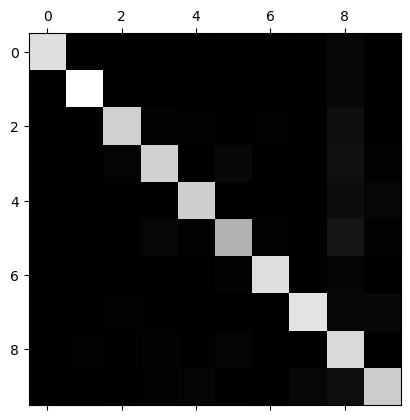

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The code below provides an alternative way to plot the same matrix, using `ConfusionMatrixDisplay` from sklearn

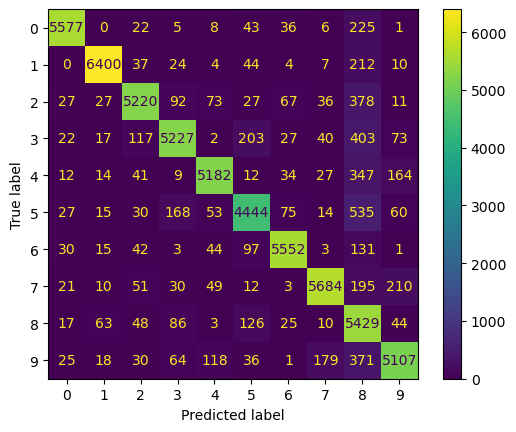

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=sgd_clf.classes_).plot()
plt.show()

Despite the matrix looks pretty good (most classifications were right), notice how low were the correct classifications for number 5.

This could be an indication that the dataset has few observations of 5's and/or the classifier makes a pretty bad work by labelling this (which are both the case).

We may verify this assumptions by plotting the normalized errors, as follows.

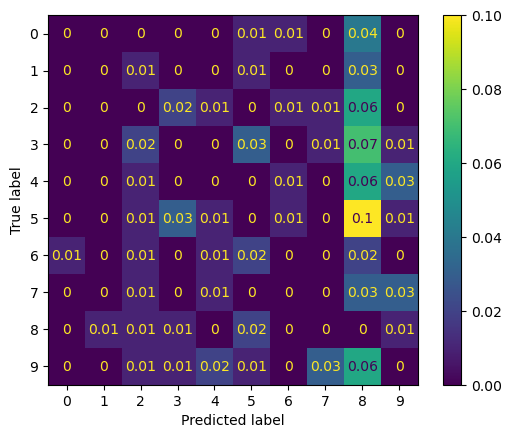

In [42]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0) # setting the main diagonal to 0's
norm_conf_mx = np.round(norm_conf_mx, 2) # rounding the numbers

ConfusionMatrixDisplay(confusion_matrix=norm_conf_mx, display_labels=sgd_clf.classes_).plot()
plt.show()

See how bad the classifications for 8's performs (there are many incorrect predictions). Also notice that 3's and 5's are sometimes confused with one another.

With that, we can better see what and where to improve, fox example, focusing on getting more reliable predictions for 8's (getting more data of the digit) and reduce the confusion among 3's and 5's. We can see, from the image below, that even us in some cases have problems to say which number it really is!!!

<img src="error_analysis.png">

## Multilabel Classification

Some algorithms do multilabel classification, for example, face recognition. Here, we will do a simple task, only to represent that it's possible to do it even for smaller tasks.

In [43]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # at least 7 
y_train_odd = (y_train % 2 == 1) # odd numbers
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [44]:
knn_clf.predict([some_digit]) # yeah, we have a right prediction (False for bigger than or equal to 7, and odd!!!)

array([[False,  True]])

In [45]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3) # might take a long
f1_score(y_multilabel, y_train_knn_pred, average="macro") # score across all labels

0.976410265560605

## Multioutput Classification

A generalization of multilabel classification is the case where each label can assume multiple classes, i.e. can assume more than one value.

We will illustrate this case by adding some noise to the MNIST images, and build a model that (hopefully) returns a clean image.

This task is multioutput because the clean images are multilabel (several digits) and also assume different values (a pixel intensity ranges from 0 to 255).

In [46]:
noise = np.random.randint(0, 100, (len(X_train), 784)) # noise
X_train_mod = X_train + noise # merge to the training data
noise = np.random.randint(0, 100, (len(X_test), 784)) # noise
X_test_mod = X_test + noise # merge to the test data
y_train_mod = X_train 
y_test_mod = X_test

# below, a noisy and a clean digit

<img src='some_digit.png'>

Now, we train a model and make a prediction

In [50]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

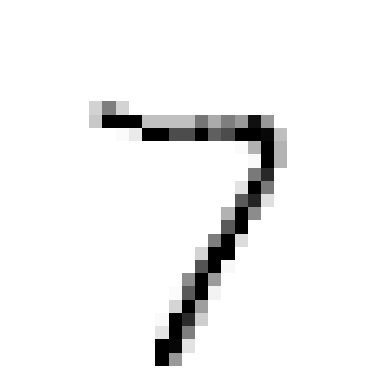

In [51]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")


plot_digit(clean_digit) # yeahh, it dit a good job!!!